# Portugal Forest Fire Analysis

#### Setup

In [1]:
%pip install -q pandas matplotlib numpy scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


## About the Data.

The forestfires.csv data set was found on kaggle.com [link](https://www.kaggle.com/datasets/ishandutta/forest-fires-data-set-portugal/data)

The data set contains information about 517 different forest fires in northeastern portugal. The columns are as follows
1. X - An X coordinate location of the fire on the Montesohino map
1. Y - A Y coordinate for the location of the fires
1. Month - the 3 letter month that the fire started on.
1. Day - the day of the week that the fire started on.
1. FFMC - The Fine Fuel Moisture Code from the Canadian Forest Fire Weather Index (FWI)
1. DMC - The Duff Moisture Code from the FWI
1. DC - The Drought Code from the FWI
1. ISI - The Initial Spread Index from the FWI
1. Temp - Temperature In Celsius 
1. RH - Relative Humidity as a %
1. Wind - The wind speed in km/h
1. Rain - the amount of rain recorded in mm/m^2
1. Area - the area in hectare of the fire.

#### Import Data

In [2]:
import pandas as pd
import numpy as np
path_to_data = 'forestfires.csv'
fire_data = pd.read_csv(path_to_data)

#### Clean data

In [3]:
#Columnwise data types, null count, and na count

In [4]:
print('Dtypes:', fire_data.dtypes)
print('************************************')
print('Null Count:',fire_data.isnull().sum())
print('************************************')
print('NA Count:', fire_data.isna().sum())

Dtypes: X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object
************************************
Null Count: X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64
************************************
NA Count: X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [5]:
#Drop X, Y, Month, and Day columns
fire_data.drop(['X', 'Y', 'month', 'day'], axis=1, inplace=True)

# Exploration

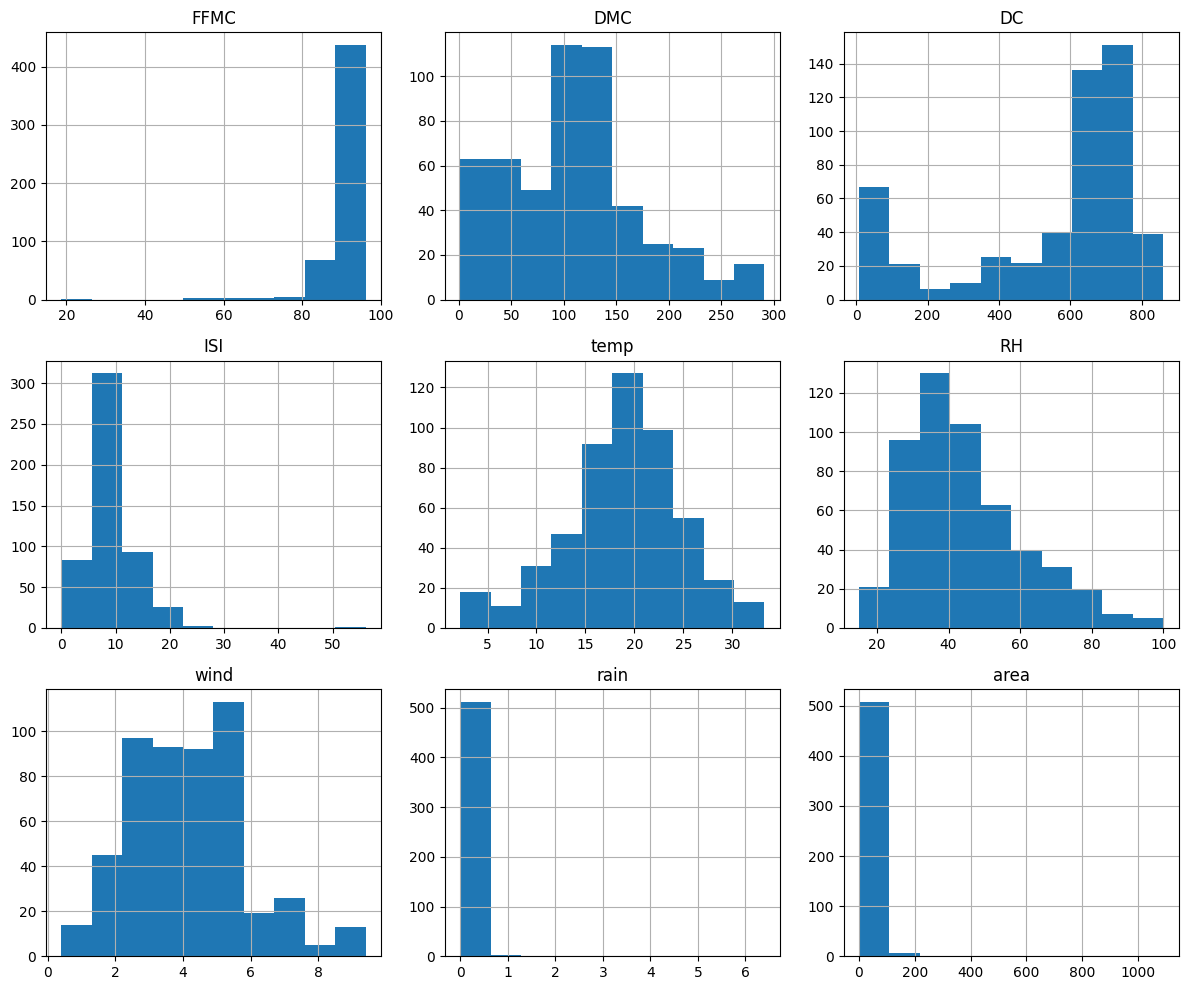

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fire_data.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

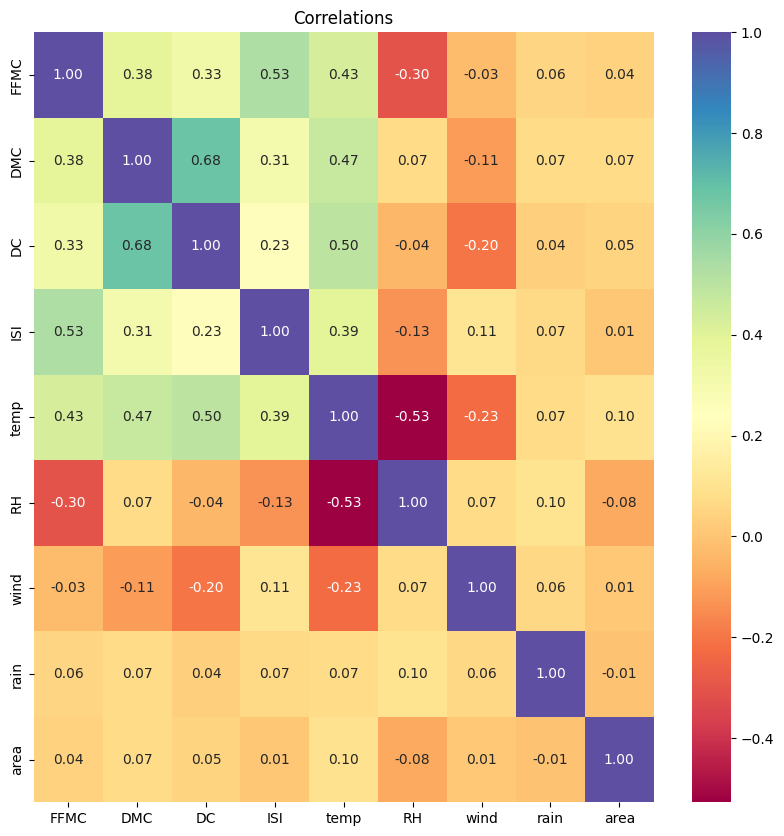

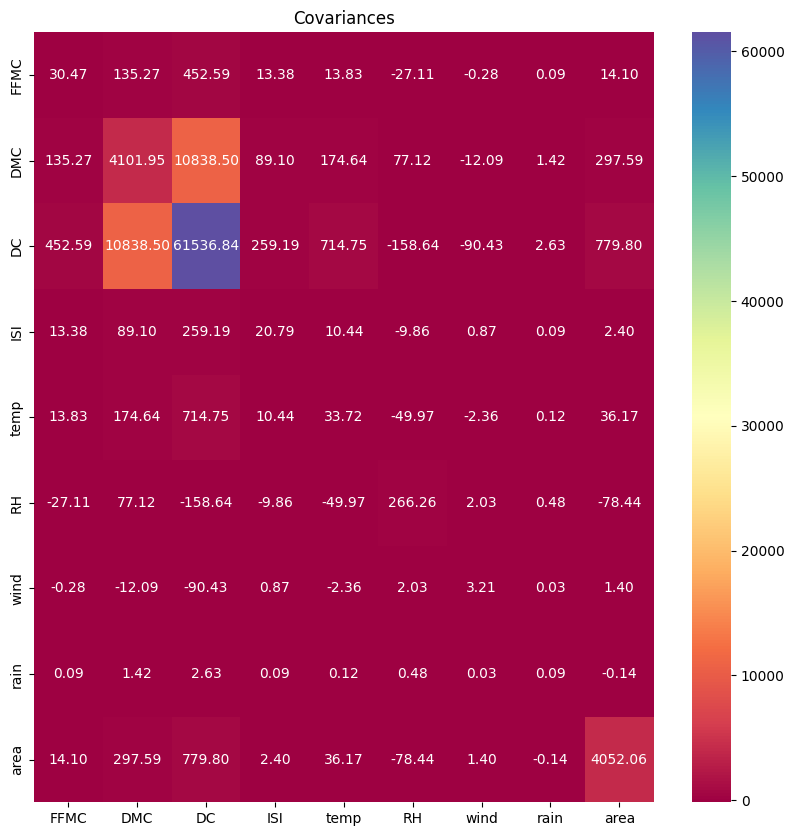

In [7]:


#Correlation matrix
corr = fire_data.corr()
plt.figure(figsize = (10 , 10))
plt.title('Correlations')
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'Spectral')
plt.show()

#Covariance matrix
plt.figure(figsize = (10 , 10))
plt.title('Covariances')
cov = fire_data.cov()
sns.heatmap(cov, annot = True, fmt = '.2f', cmap = 'Spectral')
plt.show()


# F-Test Regression

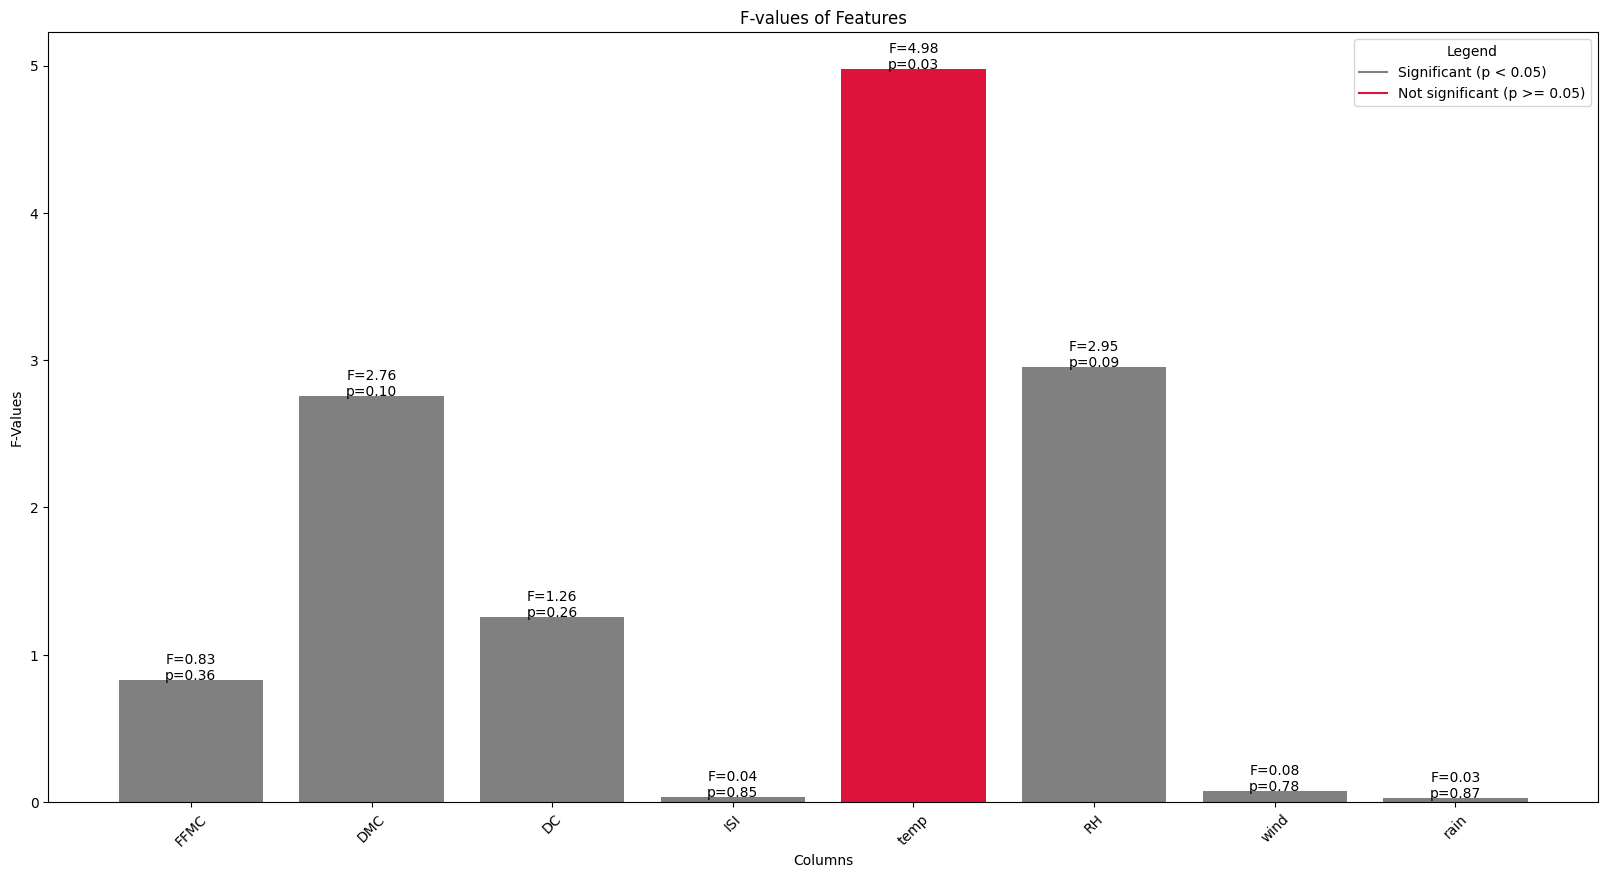

In [8]:
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

#set dependent and independent vars
X = fire_data[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']]
Y = fire_data['area'] 

#perform regression
f_vals, p_vals = f_regression(X, Y)

#bar plot for f_vals and p_vals to show feature importance
plt.figure(figsize=(20, 10))
colors = ['crimson' if p < 0.05 else 'grey' for p in p_vals]  # Green if significant, red otherwise
bars = plt.bar(range(X.shape[1]), f_vals, color=colors, tick_label=['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('F-Values')
plt.title('F-values of Features')

#f-vals and p vals as text on the bars
for i, (f_val, p_val) in enumerate(zip(f_vals, p_vals)):
    plt.text(i, f_val, f'F={f_val:.2f}\np={p_val:.2f}', ha='center')

#legend
plt.plot([], [], color='grey', label='Significant (p < 0.05)')
plt.plot([], [], color='crimson', label='Not significant (p >= 0.05)')
plt.legend(title='Legend')

plt.show()



#### Linear Regression

In [9]:
#create l-reg model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 10, shuffle = True)

lreg = LinearRegression()

scores = cross_val_score(lreg, X, Y, cv = k_folds, scoring = 'r2')

print(f"RMSE scores for each fold: {[f'{score:.2f}' for score in scores]}")
print(f"Average R2: {np.mean(scores):.2f}")

RMSE scores for each fold: ['-0.10', '-0.10', '-4.29', '0.05', '-0.01', '-6.10', '0.01', '-0.01', '0.01', '-0.08']
Average R2: -1.06


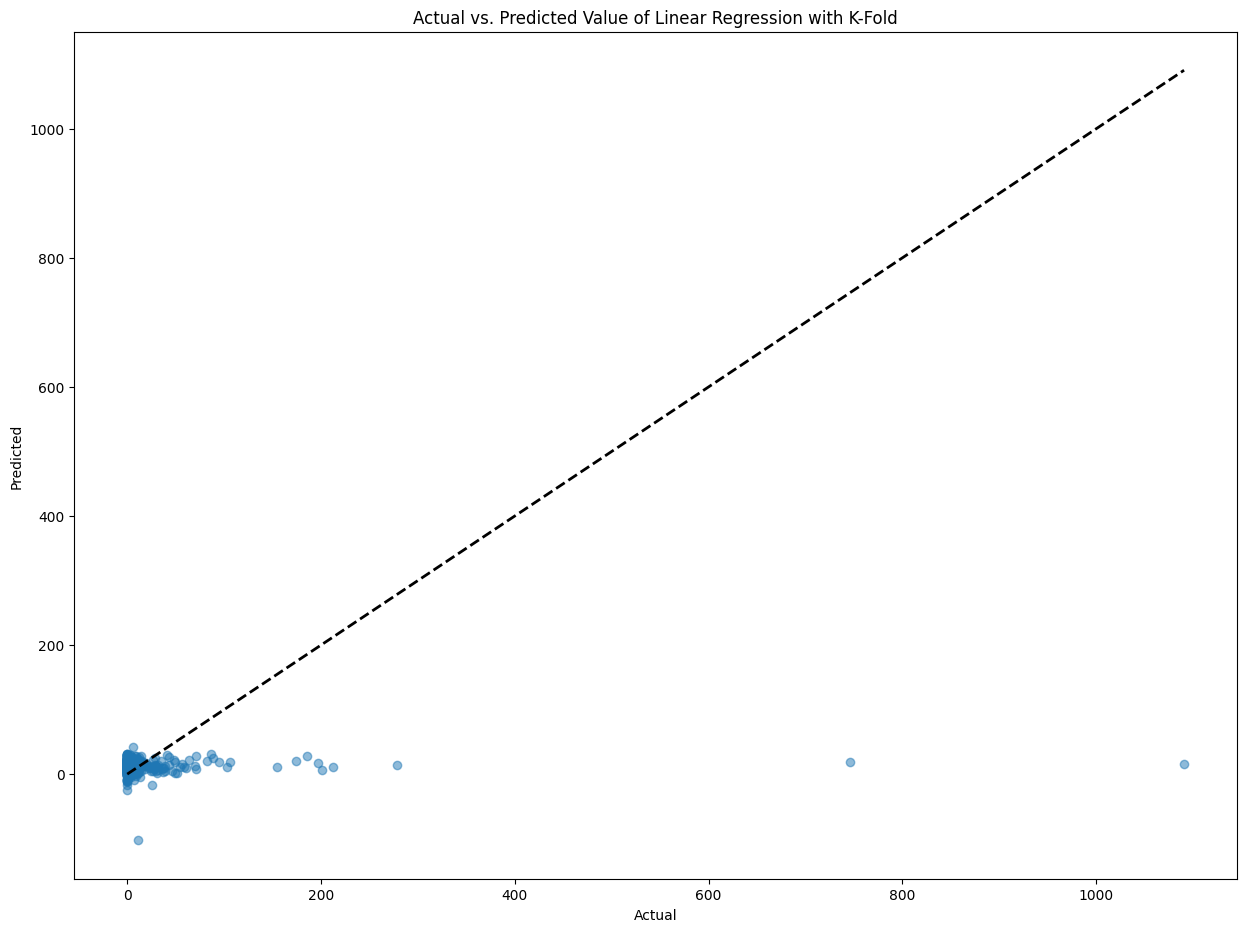

In [10]:
all_preds = []
all_y_test = []

for train_index, test_index in k_folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Fit the model and predict
    preds = lreg.fit(X_train, Y_train).predict(X_test)
    
    # Store predictions and actual values
    all_preds.extend(preds)
    all_y_test.extend(Y_test)

# Convert lists to numpy arrays for plotting
all_preds = np.array(all_preds)
all_y_test = np.array(all_y_test)

# Plot of actual vs predicted
plt.figure(figsize=(15, 11))
plt.scatter(all_y_test, all_preds, alpha=0.5)

# Perfect fit line
plt.plot([all_y_test.min(), all_y_test.max()], [all_y_test.min(), all_y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Value of Linear Regression with K-Fold')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

#### Polynomial

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score

# Prepare to collect the scores
r2_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in k_folds.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Fit the model
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    # Predict and evaluate
    Y_pred = model.predict(X_test)
    r2 = r2_score(Y_test, Y_pred)
    r2_scores.append(r2)

# Calculate average R² across all folds
average_r2 = np.mean(r2_scores)
print(f"Average R²: {average_r2}")

Average R²: -0.32536887150032123


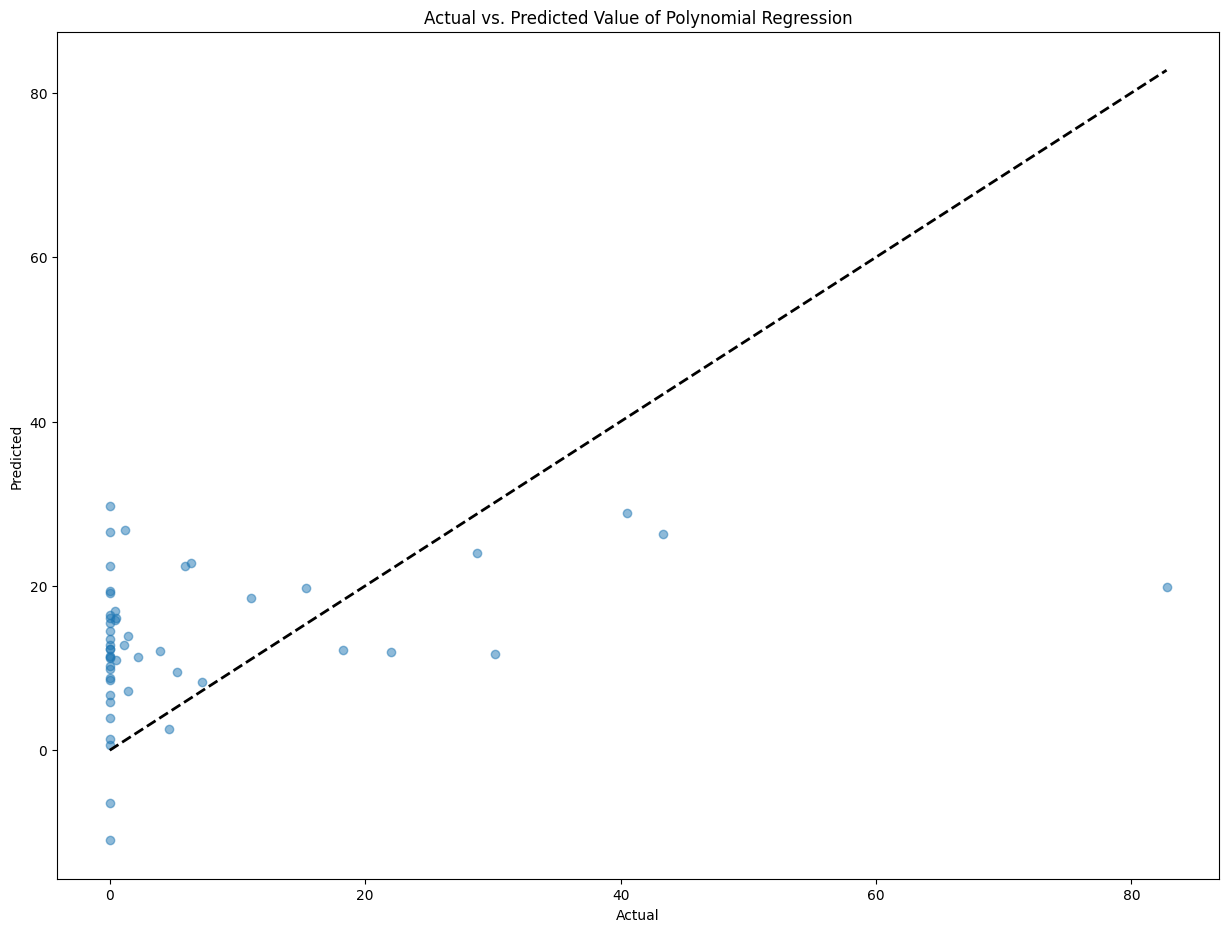

In [12]:
#plot of actual vs predicted
plt.figure(figsize = (15, 11))
plt.scatter(Y_test, Y_pred, alpha = 0.5)

#perfect fit line
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw = 2)
plt.title('Actual vs. Predicted Value of Polynomial Regression')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()


#### Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

randfore = RandomForestRegressor(n_estimators = 100) #100 trees
scores = cross_val_score(randfore, X, Y, cv = k_folds, scoring = 'r2')

print(f"RMSE scores for each fold: {[f'{score:.2f}' for score in scores]}")
print(f"Average R2: {np.mean(scores):.2f}")


RMSE scores for each fold: ['-4.08', '0.00', '0.14', '-7.08', '0.01', '-0.03', '-4.46', '-0.23', '-0.88', '-1.10']
Average R2: -1.77


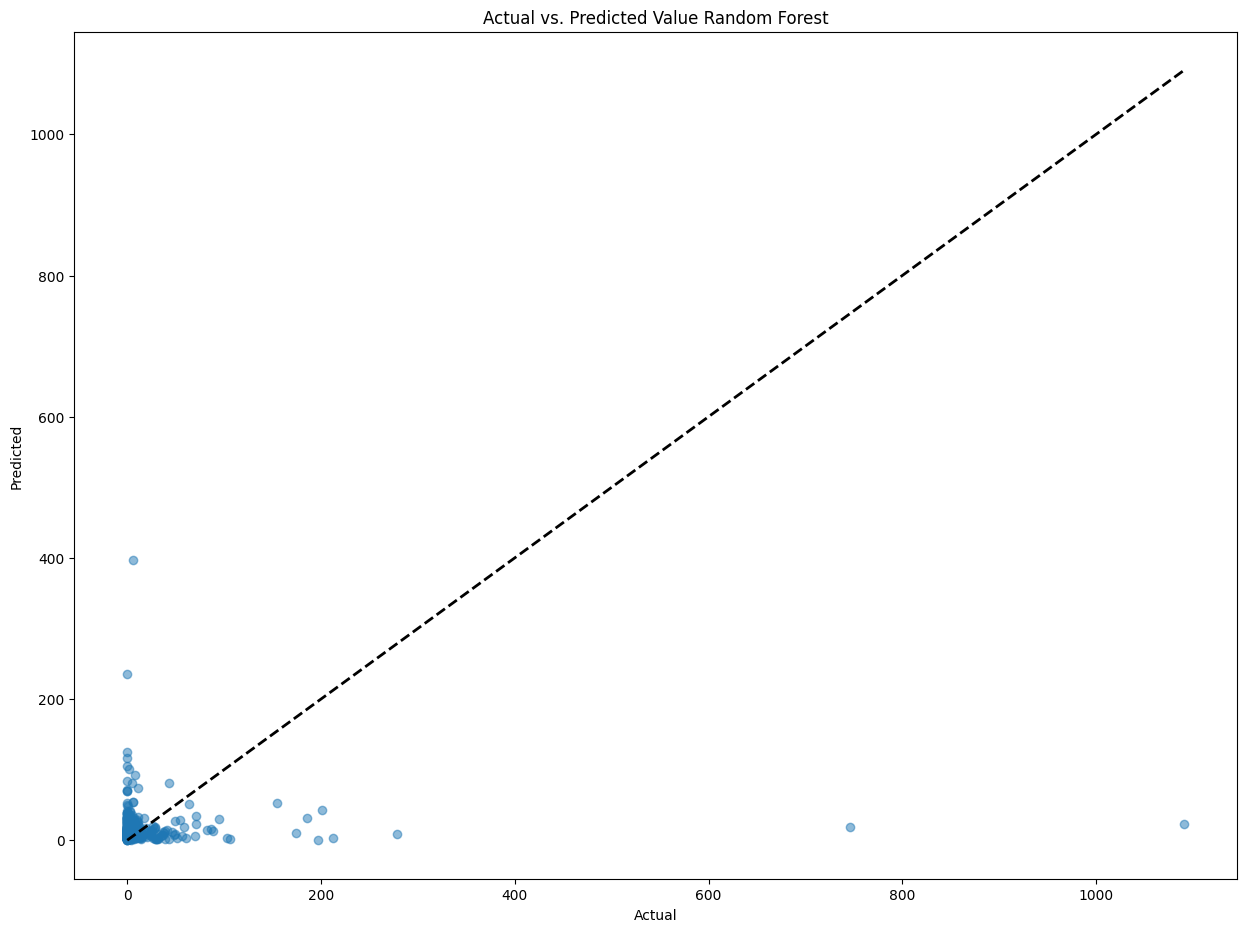

In [14]:
all_preds = []
all_y_test = []

for train_index, test_index in k_folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Fit the model and predict
    preds = randfore.fit(X_train, Y_train).predict(X_test)
    
    # Store predictions and actual values
    all_preds.extend(preds)
    all_y_test.extend(Y_test)

# Convert lists to numpy arrays for plotting
all_preds = np.array(all_preds)
all_y_test = np.array(all_y_test)

#plot of actual vs predicted
plt.figure(figsize = (15, 11))
plt.scatter(all_y_test, all_preds, alpha = 0.5)

#perfect fit line
plt.plot([all_y_test.min(), all_y_test.max()], [all_y_test.min(), all_y_test.max()], 'k--', lw = 2)
plt.title('Actual vs. Predicted Value Random Forest')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()
